In [1]:
import pickle
with open("circuit.pickle", 'rb') as handle:
    qc = pickle.load(handle)

In [3]:
calibrations = qc.calibrations
rzx_cal = calibrations['rzx']
rx_cal = calibrations['rx']

In [4]:
rx_cal.keys()

dict_keys([((0,), (0.3333333328625214,)), ((3,), (0.3333333328625215,)), ((1,), (0.33333333507070523,)), ((2,), (0.33333333507070523,))])

In [9]:
type(list(rx_cal.values())[0])

qiskit.pulse.schedule.ScheduleBlock

In [19]:
custom_rx_sched = list(rx_cal.values())[0]
print(custom_rx_sched)

ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-0.44959049003489476, amp=0.01726511975439483, angle=0), DriveChannel(0)), name="rx(0.333)", transform=AlignLeft())


In [15]:
from qiskit import QuantumCircuit
import numpy as np

circuit = QuantumCircuit(1, name='custom_rx')
circuit.rx(np.pi,0)
custom_rx = circuit.to_gate()

In [26]:
from qiskit_ibm_runtime import QiskitRuntimeService
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import InstructionProperties
from qiskit_ibm_provider import IBMProvider

In [21]:
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.get_backend('ibmq_mumbai')

In [27]:
#Setting the IBM provider
api_file = "../ibm_API_key"
with open(api_file, "r") as f:
        api_key = f.readline().strip()
provider = IBMProvider(api_key, instance='ibm-q-ncsu/nc-state/quantum-compiler')
backend = provider.get_backend('ibmq_mumbai')

In [28]:
backend.target.add_instruction(custom_rx, {(0,): InstructionProperties(calibration=custom_rx_sched)})

In [29]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [0] # make sure it is the qubit added in the backend target

int_exp = InterleavedRB(
    custom_rx, qubits, lengths, num_samples=num_samples, seed=seed, backend=backend)

In [30]:
int_expdata = int_exp.run(backend).block_for_results()
int_results = int_expdata.analysis_results()

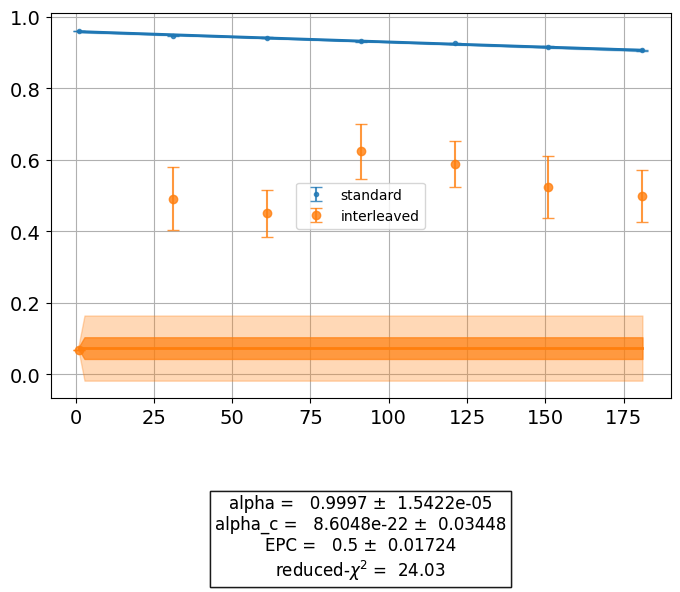

AnalysisResult
- name: @Parameters_InterleavedRBAnalysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 2
  * F_standard(x) = a * alpha ** x + b
  * F_interleaved(x) = a * (alpha_c * alpha) ** x + b
 - success: True
 - number of function evals: 65
 - degree of freedom: 10
 - chi-square: 240.30366384897965
 - reduced chi-square: 24.030366384897967
 - Akaike info crit.: 47.799844839854714
 - Bayesian info crit.: 50.35607415831575
 - init params:
  * a = 0.007524764689359059
  * alpha = 0.9993041421876363
  * b = 0.5
  * alpha_c = 0.9731458047806565
 - fit params:
  * a = 0.8852110879134342 ± 0.03034290658766372
  * alpha = 0.99966358475402 ± 1.5421824111947873e-05
  * b = 0.0729881137936446 ± 0.030336940411143973
  * alpha_c = 8.604837703730131e-22 ± 0.03447998722873101
 - correlations:
  * (a, b) = -0.9996068640226533
  * (b, alpha_c) = -0.9942691517065552
  * (alpha, b) = -0.7698563688665268
  * (a, alpha) = 0.7560034488526947
  * (alpha, alpha_c) = 

In [31]:
# View result data
display(int_expdata.figure(0))
for result in int_results:
    print(result)

c:\Users\Admin\.conda\envs\simuq\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


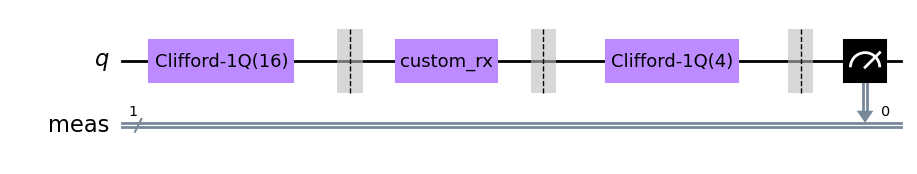

In [32]:
int_exp.circuits()[1].draw(output='mpl')

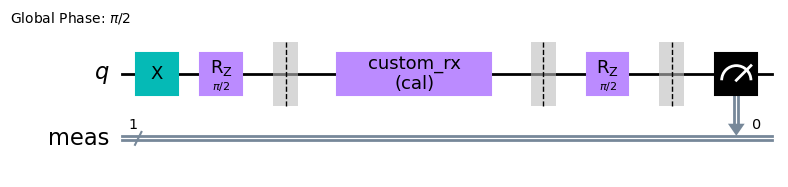

In [33]:
# you can see that the transpiled circuits contain the calibrations
int_exp._transpiled_circuits()[1].draw(output='mpl')